Import libraries

In [30]:
# import library
import numpy as np
import pandas as pd
import os

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

# Plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFile, Image

# Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

ImageFile.LOAD_TRUNCATED_IMAGES = True

Root directory

In [31]:

folder_path = 'data/'

def list_first_n_files_and_subfolders(directory_path, n=3):
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_dir():
                print(f"Directory: {entry.name}")
                # List the first 'n' files within the subfolder
                subfolder_path = os.path.join(directory_path, entry.name)
                with os.scandir(subfolder_path) as sub_entries:
                    for sub_entry in sub_entries:
                        if sub_entry.is_dir():
                            print(f"    |_ Sub-directory: {sub_entry.name}")
                            for i, item in enumerate(os.listdir(sub_entry.path)):
                                if i + 1 < n:
                                    print(f"       |_ File: {item}")
                                else:
                                    print(f"       |_ File: ....")
                                    break


list_first_n_files_and_subfolders(folder_path)

Directory: valid
    |_ Sub-directory: nowildfire
       |_ File: -73.706916,45.413078.jpg
       |_ File: -79.553188,43.813008.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -71.374,45.92116.jpg
       |_ File: -78.73456,50.15528.jpg
       |_ File: ....
Directory: test
    |_ Sub-directory: nowildfire
       |_ File: -73.89161,45.573836.jpg
       |_ File: -73.473177,45.459197.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -73.5639,46.3103.jpg
       |_ File: -68.30229,48.21163.jpg
       |_ File: ....
Directory: train
    |_ Sub-directory: nowildfire
       |_ File: -114.017676,51.127659.jpg
       |_ File: -113.967502,51.031829.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -75.79731,47.6256.jpg
       |_ File: -69.5572,51.9064.jpg
       |_ File: ....


Geospatial analysis

In [32]:
path=[]
filenames=[]
longitude=[]
latitude=[]

# Iterate through subdirectories and files
for entry in os.scandir(folder_path):
    if entry.is_dir():
        subfolder_path = os.path.join(folder_path, entry.name)
        for sub_entry in os.scandir(subfolder_path):
            if sub_entry.is_dir():
                for file in enumerate(os.listdir(sub_entry.path)):
                    # Append the file name to the DataFrame$
                    path.append(sub_entry.path+'/'+file[1])
                    filenames.append(file[1])
                    parts = file[1].split(',')
                    longitude.append(parts[0])
                    latitude.append(parts[1].split('.jp')[0])

df_pictures = pd.DataFrame({'Filename': filenames, 'Longitude': longitude, 'Latitude': latitude, 'Path': path})
# Convert 'Longitude' and 'Latitude' columns to numerical values
df_pictures['Longitude'] = pd.to_numeric(df_pictures['Longitude'])
df_pictures['Latitude'] = pd.to_numeric(df_pictures['Latitude'])


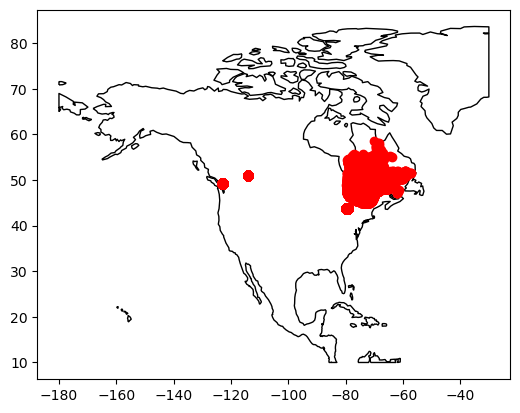

In [33]:
import geopandas
from geodatasets import get_path

gdf = geopandas.GeoDataFrame(
    df_pictures, geometry=geopandas.points_from_xy(df_pictures.Longitude, df_pictures.Latitude), crs="EPSG:4326"
)

world = geopandas.read_file(get_path("naturalearth.land"))

# We restrict to South America.
ax = world.clip([-180, 10, -30, 100]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

Density analysis

Text(0.5, 1.0, 'Density Plot of Points')

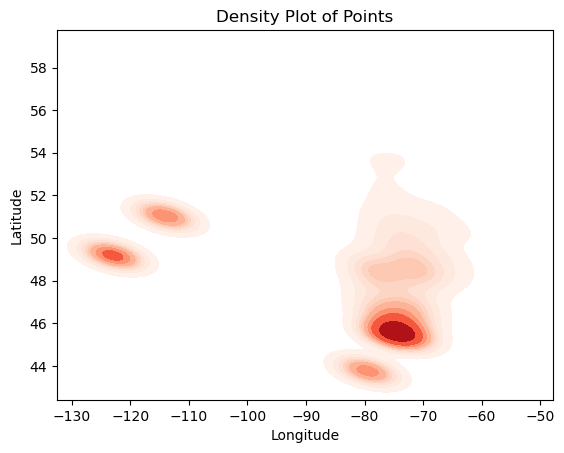

In [34]:
import seaborn as sns

# Sample data (replace with your latitude and longitude data)

# Create a density plot
sns.kdeplot(data=df_pictures, x='Longitude', y='Latitude', fill=True, cmap="Reds")

# Add labels and a title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density Plot of Points')

In [35]:
print(f'Data with longitude <-100: {len(df_pictures[df_pictures.Longitude<-100])/len(df_pictures):.2%}')

Data with longitude <-100: 20.75%


In [36]:
print(f'Data with Longitude > -100: {len(df_pictures[df_pictures.Longitude > -100]) / len(df_pictures):.2%}')

Data with Longitude > -100: 79.25%


Black scale

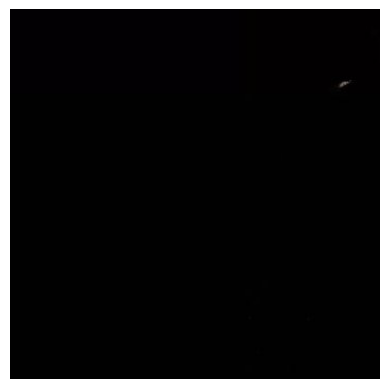

In [37]:
image_path = 'data/train/wildfire/-75.38918,49.1301.jpg'
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
black_perc=[]

for image_path in df_pictures.Path:
    img = load_img(image_path, color_mode="grayscale")
    img_array = img_to_array(img)
    # Calculate the percentage of pretty black pixels
    total_pixels = img_array.size
    black_pixels = np.count_nonzero(img_array <= 4)
    percentage_black = (black_pixels / total_pixels) * 100.0
    black_perc.append(percentage_black)
df_pictures['Black_perc']=black_perc

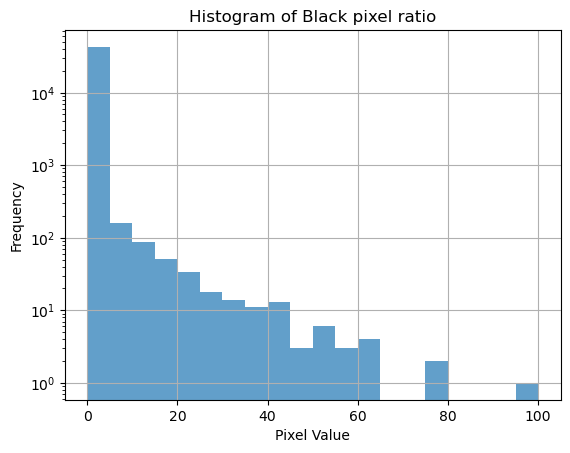

In [39]:
plt.hist(df_pictures['Black_perc'], bins=20, range=(0, 100), alpha=0.7, log=True)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Black pixel ratio')
plt.grid(True)

# Show the plot
plt.show()

In [40]:
df_pictures[(df_pictures['Black_perc']>70)]

,Filename,Longitude,Latitude,Path,Black_perc
30069,"-75.06392,45.98142.jpg",-75.06392,45.98142,"data/train/wildfire/-75.06392,45.98142.jpg",78.565714
31122,"-74.7497,46.5136.jpg",-74.74970,46.51360,"data/train/wildfire/-74.7497,46.5136.jpg",77.403265
41879,"-75.38918,49.1301.jpg",-75.38918,49.13010,"data/train/wildfire/-75.38918,49.1301.jpg",99.900408


Read data

In [68]:
train_dir = 'data/train'
test_dir = 'data/test'
valid_dir = 'data/valid'

rescale_datagen = ImageDataGenerator(dtype='float32',
                                     rescale= 1./255.,
                                     rotation_range=10,
                                     zoom_range=0.05,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.15,
                                     horizontal_flip=True,
                                     fill_mode="nearest")
train_generator = rescale_datagen.flow_from_directory(train_dir, 
                                                      batch_size = 50, 
                                                      target_size = (224,224),
                                                      color_mode = "rgb",
                                                      class_mode = "categorical",
                                                      shuffle = True,
                                                      seed = 42)
valid_generator = rescale_datagen.flow_from_directory(valid_dir,
                                                      batch_size = 50,
                                                      target_size = (224,224),
                                                      color_mode = "rgb",
                                                      class_mode = "categorical",
                                                      shuffle = True,
                                                      seed = 42)
test_generator = rescale_datagen.flow_from_directory(test_dir,
                                                     batch_size = 50,
                                                     target_size = (224,224),
                                                     color_mode = "rgb",
                                                     class_mode = "categorical",
                                                     shuffle = False,
                                                     seed = 42)


#Class_mode as categorical:
#the labels are categorical (one-hot encoded)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


Label encoding

In [42]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['nowildfire', 'wildfire']

In [43]:
train_generator.class_indices

{'nowildfire': 0, 'wildfire': 1}

Distribution of classes among the dataset (tain + validation + test)

In [44]:
# Calculate class weights manually based on class distribution
class_labels = np.unique(valid_generator.classes)
class_distribution = np.bincount(train_generator.classes) + np.bincount(valid_generator.classes) + np.bincount(test_generator.classes)
total_samples = np.sum(class_distribution)
class_weights = total_samples / (len(class_labels) * class_distribution)

class_weights /= np.sum(class_weights)

# Create a dictionary of class weights
class_weight_dict = {class_index: weight for class_index, weight in enumerate(np.round(class_weights,2))}
class_weight_dict

{0: 0.53, 1: 0.47}

Plot some pictures

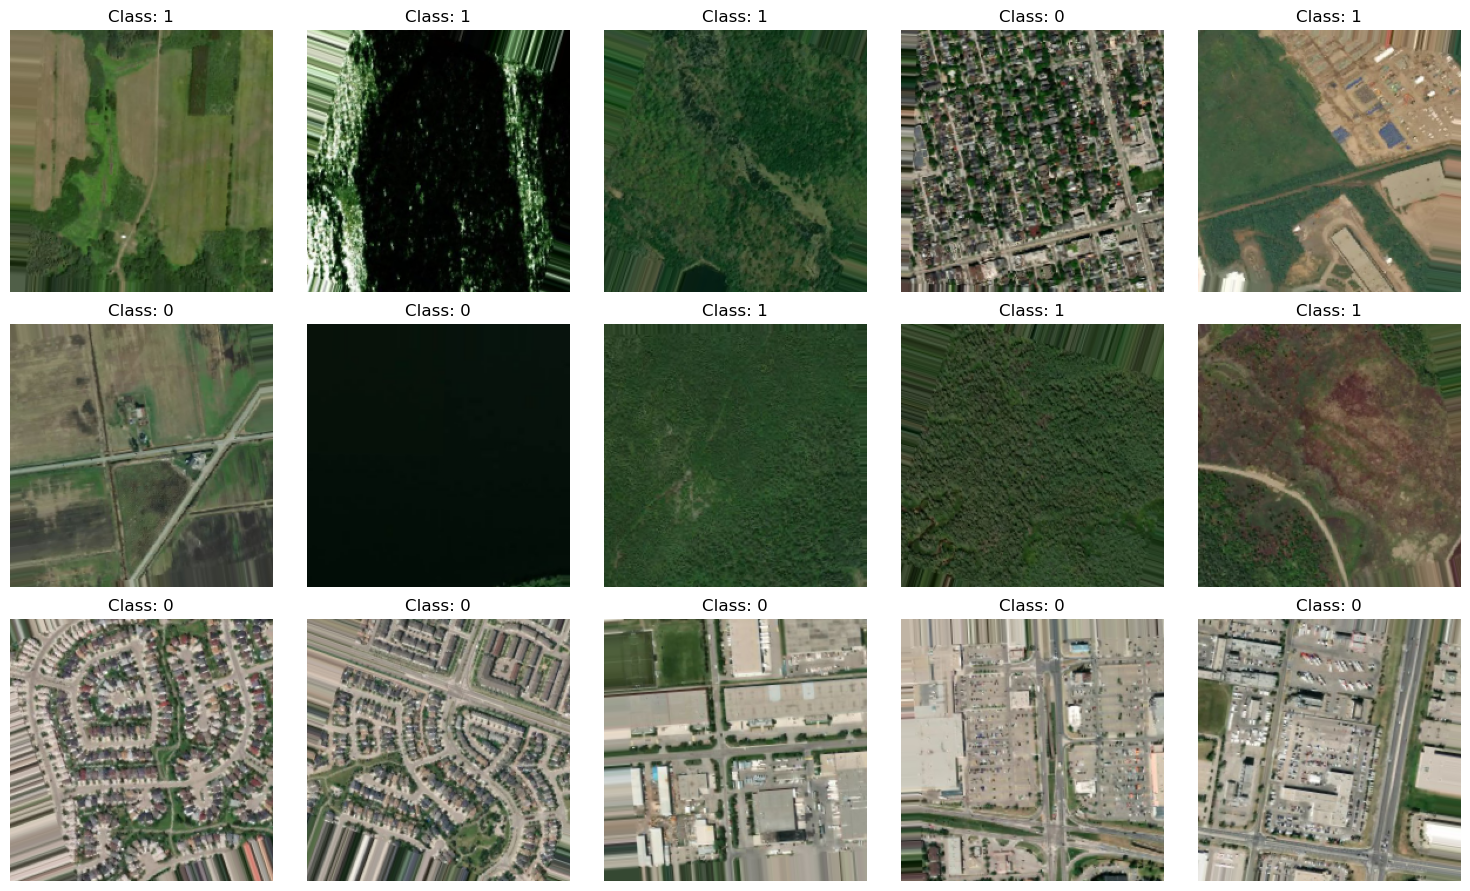

In [69]:
import matplotlib.pyplot as plt
import random

# Set the number of random images to plot
num_images_to_plot = 5

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, num_images_to_plot, figsize=(15, 9))  # Adjust figsize as needed

# Iterate through the generator to get random images
for i in range(3):
    for j in range(num_images_to_plot):
        # Get a random batch based on the row (train, valid, or test)
        if i == 0:
            batch = next(train_generator)
        elif i == 1:
            batch = next(valid_generator)
        else:
            batch = next(test_generator)
        
        images, labels = batch
        
        # Select a random image from the batch
        random_index = random.randint(0, len(images) - 1)
        image_to_plot = images[random_index]
        label_to_plot = labels[random_index]

        # Plot the selected image on the corresponding subplot
        axes[i, j].imshow(image_to_plot)
        axes[i, j].set_title(f"Class: {label_to_plot.argmax()}")  # Assuming one-hot encoded labels
        axes[i, j].axis('off')  # Turn off axis labels

# Adjust spacing between subplots for better layout
plt.tight_layout()
plt.show()

First model

In [70]:
# Dense neural networks
model1 = Sequential([
    # input layer: Flatten the input images to a 1D vector
    Flatten(input_shape=(224, 224, 3)),
    
    # fully connected layers:
    Dense(units = 128, activation = 'elu', kernel_initializer="he_normal"),
    Dense(units = 128, activation = 'elu', kernel_initializer="he_normal"),
    Dense(units = 64, activation = 'elu', kernel_initializer="he_normal"),
    Dense(units = 32, activation = 'elu', kernel_initializer="he_normal"),
    
    # output layer
    Dense(units = 2, activation = 'sigmoid')
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_22 (Dense)            (None, 128)               19267712  
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 2)                 66        
                                                                 
Total params: 19,294,626
Trainable params: 19,294,626


In [71]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

logs1 = model1.fit(train_generator,
                   epochs = 20,
                   steps_per_epoch = 30250/50,
                   validation_data = valid_generator,
                   validation_steps = 6300/50,
                   callbacks=[callback])

Epoch 1/20
605/605 [==============================] - 188s 311ms/step - loss: 0.9551 - accuracy: 0.8165 - val_loss: 0.3333 - val_accuracy: 0.8557
Epoch 2/20
605/605 [==============================] - 189s 312ms/step - loss: 0.3593 - accuracy: 0.8558 - val_loss: 0.2863 - val_accuracy: 0.8856
Epoch 3/20
605/605 [==============================] - 188s 311ms/step - loss: 0.3111 - accuracy: 0.8717 - val_loss: 0.2614 - val_accuracy: 0.8971
Epoch 4/20
605/605 [==============================] - 188s 311ms/step - loss: 0.3668 - accuracy: 0.8556 - val_loss: 0.2619 - val_accuracy: 0.8943
Epoch 5/20
605/605 [==============================] - 188s 311ms/step - loss: 0.2911 - accuracy: 0.8798 - val_loss: 0.2780 - val_accuracy: 0.8787
Epoch 6/20
605/605 [==============================] - 188s 311ms/step - loss: 0.2931 - accuracy: 0.8803 - val_loss: 0.2718 - val_accuracy: 0.8856
Epoch 7/20
605/605 [==============================] - 188s 311ms/step - loss: 0.2971 - accuracy: 0.8781 - val_loss: 0.3081 -

Plot of the fitting steps

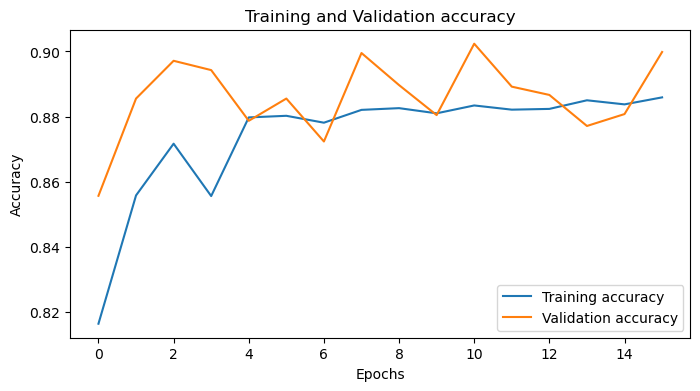

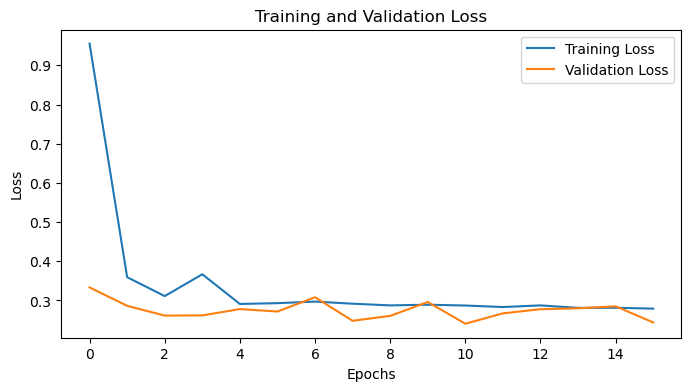

In [72]:
logs = logs1

# Get the training and validation accuracy and loss
training_accuracy = logs.history['accuracy']
validation_accuracy = logs.history['val_accuracy']

# Get the training and validation loss
training_loss = logs.history['loss']
validation_loss = logs.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Evaluation

In [73]:
result = model1.evaluate(test_generator, steps=6300/50)

126/126 [==============================] - 32s 256ms/step - loss: 0.2417 - accuracy: 0.9049


Confusion matrix

126/126 [==============================] - 32s 254ms/step


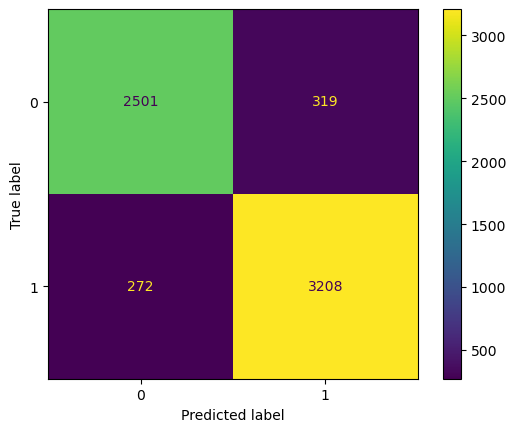

In [74]:
test_generator.reset()
prediction = model1.predict(test_generator)
y_prediction = np.argmax(prediction, axis=1)

conf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_prediction)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

Accuracy

In [75]:
acc = accuracy_score(y_true=test_generator.classes, y_pred=y_prediction)
print(f"Accuracy of the model1: {acc*100:.2f}%")

Accuracy of the model1: 90.62%


Model2: Convolutional neural network

In [76]:
# building neural networks
model2 = Sequential([
    # Conv layer 1:
    Conv2D(32, (3, 3), input_shape=(228,228,3), activation='elu', kernel_initializer ='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 2:
    Conv2D(16, (3, 3), activation='elu', kernel_initializer ='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 3:
    Conv2D(16, (3, 3), activation='elu', kernel_initializer ='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    
    Flatten(),
    
    # fully connected layers:
    Dense(units = 128, activation = 'elu'),
    Dense(units = 2, activation = 'softmax')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 226, 226, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 113, 113, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 111, 111, 16)      4624      
                                                                 
 batch_normalization_7 (Batc  (None, 111, 111, 16)     64        
 hNormalization)                                                 
                                                      

Train the model

In [77]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

logs2 = model2.fit(train_generator,
                   epochs = 10,
                   steps_per_epoch=30250/50,
                   validation_data = valid_generator,
                   validation_steps=6300/50,
                   callbacks=[callback])

Epoch 1/10
605/605 [==============================] - 279s 461ms/step - loss: 0.2640 - accuracy: 0.9181 - val_loss: 0.2032 - val_accuracy: 0.9170
Epoch 2/10
605/605 [==============================] - 280s 462ms/step - loss: 0.1721 - accuracy: 0.9336 - val_loss: 0.1538 - val_accuracy: 0.9454
Epoch 3/10
605/605 [==============================] - 300s 496ms/step - loss: 0.1620 - accuracy: 0.9379 - val_loss: 0.1664 - val_accuracy: 0.9368
Epoch 4/10
605/605 [==============================] - 292s 483ms/step - loss: 0.1644 - accuracy: 0.9374 - val_loss: 0.2233 - val_accuracy: 0.9152
Epoch 5/10
605/605 [==============================] - 1575s 3s/step - loss: 0.1502 - accuracy: 0.9418 - val_loss: 0.1310 - val_accuracy: 0.9503
Epoch 6/10
605/605 [==============================] - 280s 462ms/step - loss: 0.1433 - accuracy: 0.9454 - val_loss: 0.5533 - val_accuracy: 0.8471
Epoch 7/10
605/605 [==============================] - 279s 461ms/step - loss: 0.1365 - accuracy: 0.9482 - val_loss: 0.6075 - v

Evaluation

In [78]:
result = model2.evaluate(test_generator, steps=6300/50)

126/126 [==============================] - 34s 272ms/step - loss: 0.0977 - accuracy: 0.9662


Confusion matrix

126/126 [==============================] - 38s 304ms/step


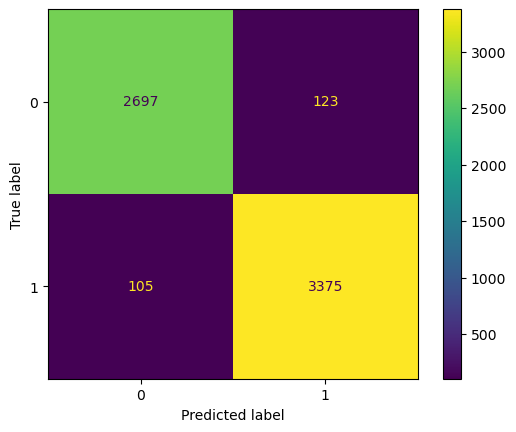

In [79]:
test_generator.reset()
prediction = model2.predict(test_generator)
y_prediction = np.argmax(prediction, axis=1)

conf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_prediction)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

Accuracy

In [80]:
acc = accuracy_score(y_true=test_generator.classes, y_pred=y_prediction)
print(f"Accuracy of CNN model: {acc*100:.1f}%")

Accuracy of CNN model: 96.4%


With VGG16

In [81]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg_model.layers:
    layer.trainable=False

model3 = Sequential([
    vgg_model,
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=2, activation='softmax')
])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_29 (Dense)            (None, 256)               6422784   
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 2)                 258       
                                                                 
Total params: 21,170,626
Trainable params: 6,455,938
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

logs3 = model3.fit(train_generator,
                   epochs = 10,
                   steps_per_epoch=30250/50,
                   validation_data = valid_generator,
                   validation_steps=6300/50,
                   callbacks=[callback])


126/126 [==============================] - 321s 3s/step


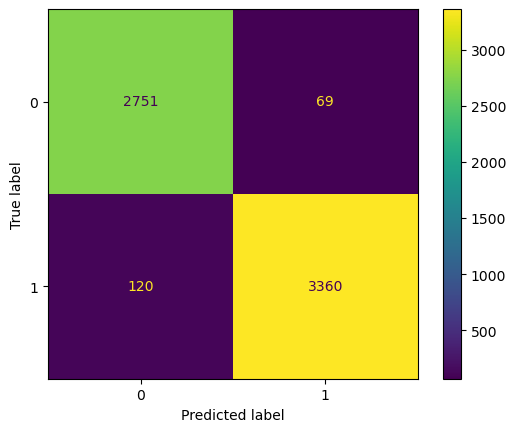

In [82]:
from tensorflow.keras.models import load_model

model4= load_model("Model3.h5")
test_generator.reset()
prediction = model4.predict(test_generator)
y_prediction = np.argmax(prediction, axis=1)

conf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_prediction)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

In [83]:
acc = accuracy_score(y_true=test_generator.classes, y_pred=y_prediction)
print(f"Accuracy of CNN model: {acc*100:.1f}%")

Accuracy of CNN model: 97.0%


Prediction on new picture (out of the dataset)

In [ ]:
url = "https://www.peacearchnews.com/news/photo-satellite-imagery-shows-origin-of-wildfire-smoke-2844866"
tempfile_path =tempfile.mktemp()
urllib.request.urlretrieve(url, tempfile_path)


new_image = load_img(tempfile_path, target_size=(224,224))

im=plt.imshow(np.asarray(new_image))
im
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0  # Normalize the image

# Extract features from the new image using VGG16 model
new_features = vgg16.predict(new_image)

# Make prediction on the new image
prediction = model2.predict(new_features)
print(prediction)
predicted_label = np.argmax(prediction)
print(predicted_label)
print("Predicted label:", class_labels[predicted_label])

NameError: name 'tempfile' is not defined